# **T-Cell Activation Classification**
**Project  Title:** T-Cell Activation Classification Model

**Course:** Machine Learning for the Life Sciences (BSCI238I) – Fall 2025

**Author:** Catherine Smith


### **Background**


This project develops a machine-learning model that predicts whether a T-cell is active or quiescent using quantitative features extracted from fluorescence microscopy images.

Using classification modeling, data cleaning, feature analysis, standardization, SGD-based training, and evaluation, the project identifies which features most strongly predict T-cell activation status in human immune cells.

This project demonstrates:

* Data cleaning & preprocessing

* Exploratory data analysis

* Correlation-based feature selection

* Train/validation/test splitting

* Standardization

* Logistic regression (or linear classifiers) with stochastic gradient descent

* Model evaluation (accuracy, confusion matrix, ROC curve, residual analysis)

* Model interpretation with standardized & unstandardized coefficients

###**References**

**References**

  Walsh, A. J., Mueller, K., Tweed, K., Jones, I., Walsh, C. M., Piscopo,
    N., Niemi, N. M., Pagliarini, D. J., Saha, K., & Skala, M. C. (2021). Classification of T-cell activation via autofluorescence lifetime imaging. Nature Biomedical Engineering, 5(1), 77–88. https://doi.org/10.1038/s41551-020-0592-z

  Wang, Z. J., Walsh, A. J., Skala, M. C., & Gitter, A. (2020).
    Classifying T cell activity in autofluorescence intensity images with convolutional neural networks. Journal of Biophotonics, 13(3), e201960050. https://doi.org/10.1002/jbio.201960050

[Carpentries](https://carpentries-incubator.github.io/ml4bio-workshop/02-T-cells/index.html).

## **Prepare Data**

### **Load Data**

In [6]:
# Load libraries and dataset
!pip install graphviz

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import graphviz
from sklearn.tree import export_graphviz
from io import StringIO

MY_RANDOM_STATE = 42

# Load T-cell feature dataset
url = "https://raw.githubusercontent.com/carpentries-incubator/ml4bio-workshop/master/data/t_cell/size_intensity_feature.csv"
df = pd.read_csv(url)

In [7]:
X = df[['cell_size', 'total_intensity']]
y = df['class']

### **Split Data**

In [8]:
# Split data using stratified sampling

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(y_test)

541    quiescent
72     quiescent
714    activated
122    quiescent
654    activated
         ...    
149    quiescent
272    activated
689    activated
309    activated
307    activated
Name: class, Length: 253, dtype: object


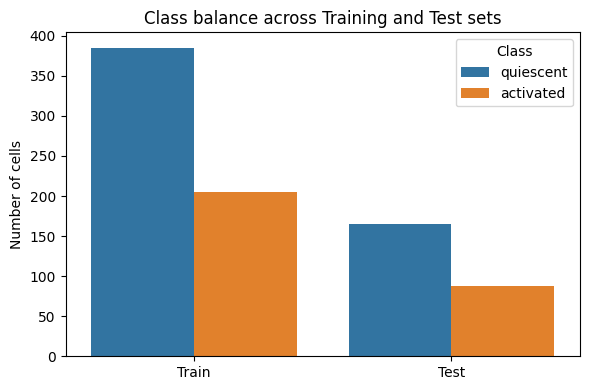


Overall class distribution:


,proportion
class,
quiescent,65.2%
activated,34.8%



Train class distribution:


,proportion
class,
quiescent,65.3%
activated,34.7%



Test class distribution:


,proportion
class,
quiescent,65.2%
activated,34.8%


In [9]:
# Generate class distribution plot

split_df = pd.concat([
    pd.DataFrame({"split": "Train", "label": y_train}),
    pd.DataFrame({"split": "Test",  "label": y_test})
], ignore_index=True)

plt.figure(figsize=(6,4))
sns.countplot(data=split_df, x="split", hue="label")

plt.title("Class balance across Training and Test sets")
plt.ylabel("Number of cells")
plt.xlabel("")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

# Generate tables to show class distribution

print("\nOverall class distribution:")
display(pd.Series(y).value_counts(normalize=True).mul(100).round(1).astype(str) + "%")

print("\nTrain class distribution:")
display(pd.Series(y_train).value_counts(normalize=True).mul(100).round(1).astype(str) + "%")

print("\nTest class distribution:")
display(pd.Series(y_test).value_counts(normalize=True).mul(100).round(1).astype(str) + "%")


## **Train and Evaluate Model**

###**Logistic Regression**

#### **Model Training**

In [10]:
# Train logistic model
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

#### **Model Testing**

In [11]:
# Accuracy
acc = accuracy_score(y_test, logreg.predict(X_test))
print(f"Logistic Regression Accuracy: {acc:.3f}")

Logistic Regression Accuracy: 0.822


#### **Model Interpretation**

In [12]:
# Print the regression equation
b0 = logreg.intercept_[0]
b1, b2 = logreg.coef_[0]
print("\nLogistic Regression equation (logit scale):")
print(f"  logit(p) = {b0:.6f} + ({b1:.6f} × cell_size) + ({b2:.6f} × total_intensity)\n\n")


Logistic Regression equation (logit scale):
  logit(p) = 0.007895 + (0.013857 × cell_size) + (-0.000183 × total_intensity)




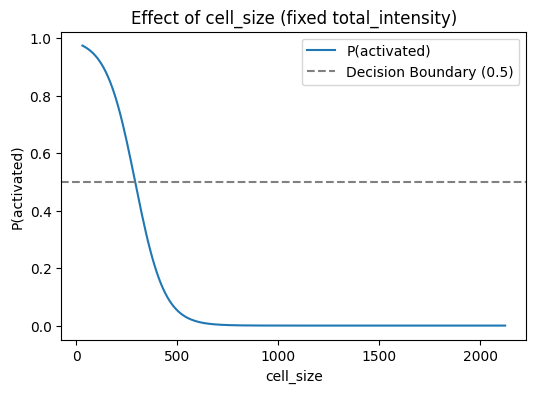

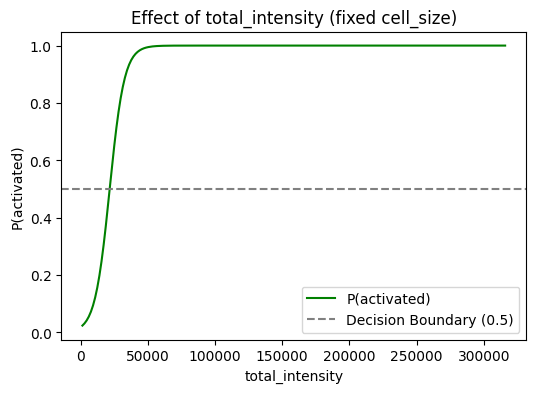

In [13]:
# Effect of cell_size at mean total_intensity
mean_ti = df['total_intensity'].mean()
cs = np.linspace(df['cell_size'].min(), df['cell_size'].max(), 200)
df_cs = pd.DataFrame({
    'cell_size': cs,
    'total_intensity': mean_ti
})
probs_cs = logreg.predict_proba(df_cs)[:, logreg.classes_.tolist().index('activated')]

plt.figure(figsize=(6,4))
plt.plot(cs, probs_cs, label='P(activated)')
plt.axhline(0.5, color='gray', linestyle='--', label='Decision Boundary (0.5)')
plt.xlabel('cell_size')
plt.ylabel('P(activated)')
plt.title('Effect of cell_size (fixed total_intensity)')
plt.legend()
plt.show()

# Effect of total_intensity at mean cell_size
mean_cs = df['cell_size'].mean()
ti = np.linspace(df['total_intensity'].min(), df['total_intensity'].max(), 200)
df_ti = pd.DataFrame({
    'cell_size': mean_cs,
    'total_intensity': ti
})
probs_ti = logreg.predict_proba(df_ti)[:, logreg.classes_.tolist().index('activated')]

plt.figure(figsize=(6,4))
plt.plot(ti, probs_ti, color='green', label='P(activated)')
plt.axhline(0.5, color='gray', linestyle='--', label='Decision Boundary (0.5)')
plt.xlabel('total_intensity')
plt.ylabel('P(activated)')
plt.title('Effect of total_intensity (fixed cell_size)')
plt.legend()
plt.show()

###**K-Nearest-Neighbors**

#### **K Value Selection**

In [14]:
candidate_ks = [1, 2, 3, 5, 7, 10, 15, 20, 50, 75, 79, 80, 90, 100, 110, 120, 125, 150, 200, 500]

print("K   | Accuracy")
print("-"*30)

for k in candidate_ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    test_acc  = accuracy_score(y_test,  knn.predict(X_test))
    print(f"{k:<3} | {test_acc:8.3f}")


K   | Accuracy
------------------------------
1   |    0.802
2   |    0.818
3   |    0.798
5   |    0.806
7   |    0.802
10  |    0.818
15  |    0.826
20  |    0.814
50  |    0.830
75  |    0.850
79  |    0.854
80  |    0.854
90  |    0.854
100 |    0.854
110 |    0.854
120 |    0.854
125 |    0.850
150 |    0.830
200 |    0.818
500 |    0.652


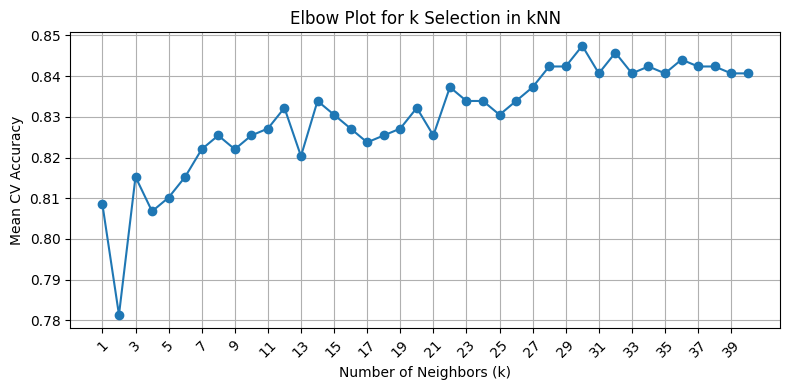

In [15]:
# Pick a range of k values to test
k_values = list(range(1, 41))
cv_scores = []

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=MY_RANDOM_STATE)

for k in k_values:
    knn_cv = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_cv, X_train, y_train, cv=kf, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean CV Accuracy')
plt.title('Elbow Plot for k Selection in kNN')
plt.xticks(k_values[::2], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
optimal_k = 30

#### **Model Training**

In [17]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

#### **Model Testing**

In [18]:
y_pred = knn_optimal.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (k={optimal_k}): {test_acc:.3f}")

Test Accuracy (k=30): 0.802


###**Decision Trees**

#### **Model Training**

In [19]:
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

#### **Model Testing**

In [20]:
y_pred_dt = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Test Accuracy (max_depth=5): {dt_accuracy:.4f}")

Decision Tree Test Accuracy (max_depth=5): 0.8617


#### **Model Interpretation**

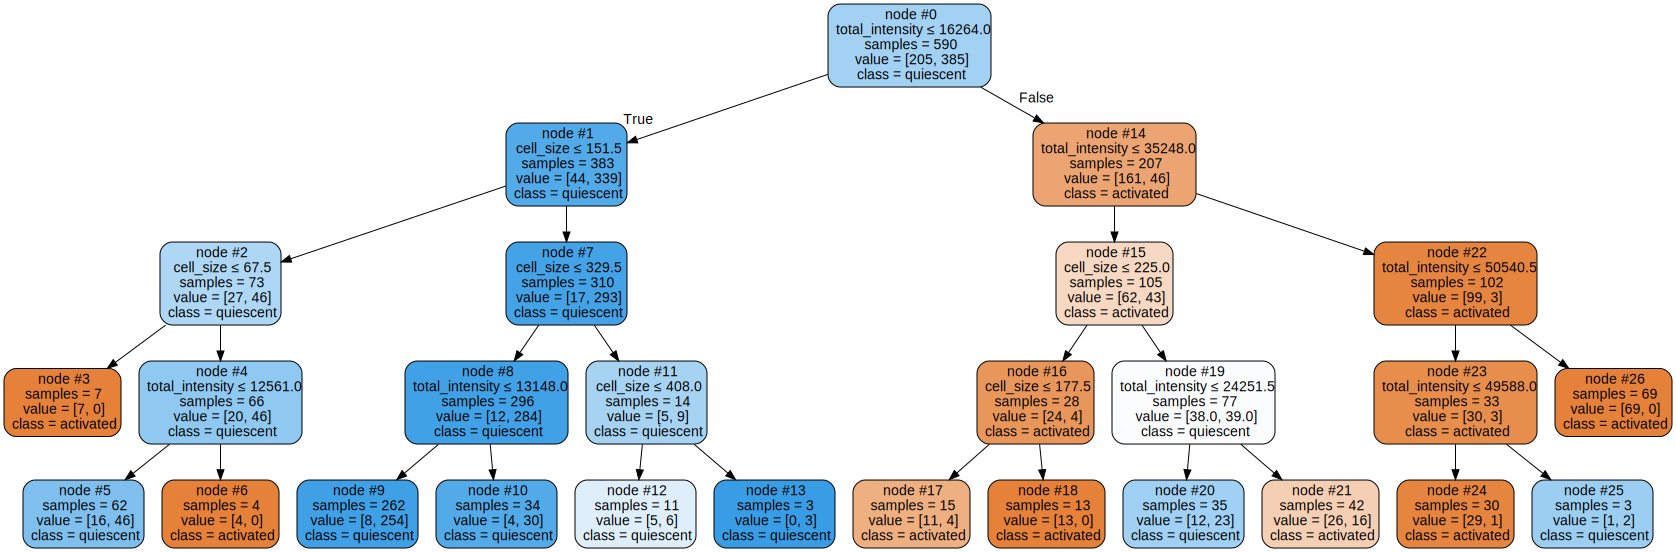

In [21]:
feature_names = X_train.columns.tolist()
class_names = dt_model.classes_.tolist()

dot_data = StringIO()
export_graphviz(
    dt_model,
    out_file=dot_data,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    special_characters=True,
    proportion=False,
    node_ids=True,
    impurity=False,
)

graph = graphviz.Source(dot_data.getvalue())
display(graph)